# 1. Import Libraries

In [71]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from ydata_profiling import ProfileReport
from phik import phik_matrix

%matplotlib inline

# 2. Data Download from Kaggle

In [72]:
out_path = "../Data/Raw/"
import kagglehub
import shutil

# Download latest version
#path = kagglehub.dataset_download("brandao/diabetes")
#shutil.move(path, out_path)
raw_df = pd.read_csv("../Data/Raw/1/diabetic_data.csv")
raw_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# 3. Initial Data Inspection

In [73]:
print(raw_df.head())
print(raw_df.shape)
print(raw_df.info())
print(raw_df.describe())

# Duplicates check
print("Unique encounter_id:", raw_df["encounter_id"].nunique())
print("Total rows:", len(raw_df))


   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [74]:
# Raw Data Profiling Report
profile = ProfileReport(raw_df, title="Raw Data Profiling", explorative=True)
profile.to_file("../Reports/pydata_profiling/diabetes_report_rawData.html")
print("Raw profiling report saved.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 29.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Raw profiling report saved.


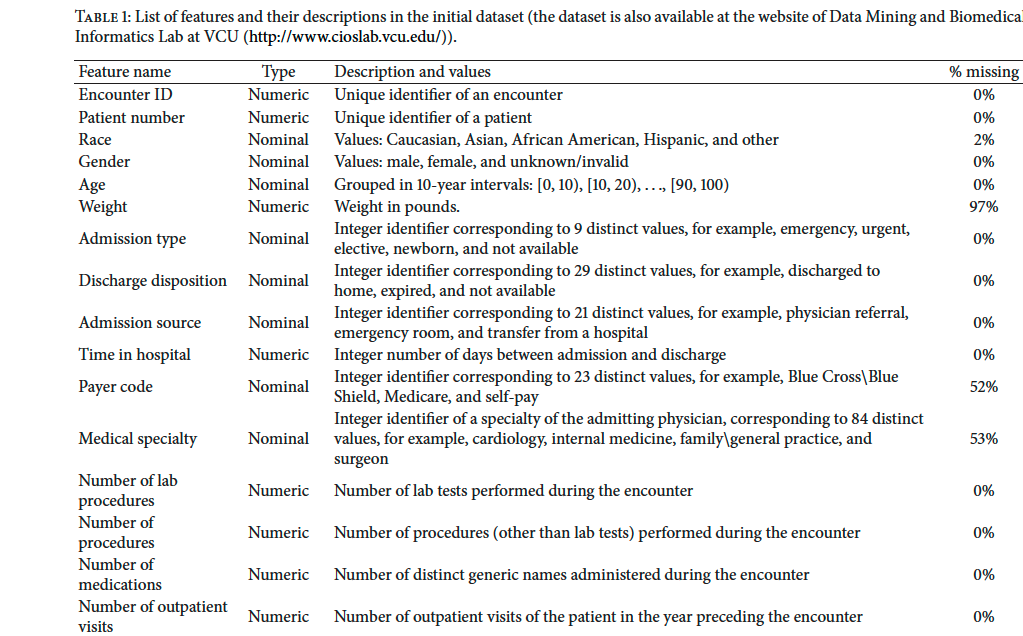
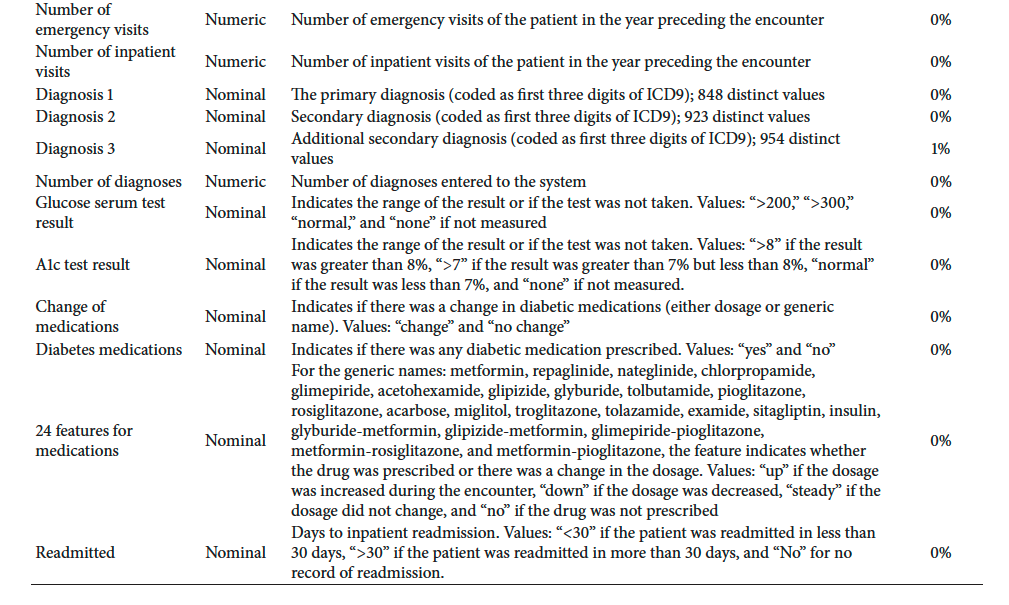

## 4. Data Cleaning and Transformation

(a) Drop unwanted columns

Action,Details
A. Derive Historical Features,"Using the patient_nbr column, calculate these features for each encounter, using only prior encounter data: <ul><li>patient_prior_encounters: Count of previous visits.</li><li>days_since_last_encounter: Time difference (in days) between the current encounter and the last one.</li><li>patient_historical_readmission_rate: The proportion of prior encounters that resulted in a <30 day readmission.</li></ul>"
B. Drop patient_nbr,"After creating the historical features, the original patient_nbr must be dropped from the feature set to prevent the model from using it as a high-cardinality ID."

In [75]:
print(len(raw_df.encounter_id))
print(len(raw_df.encounter_id.unique()))
print(len(raw_df.patient_nbr))
print(len(raw_df.patient_nbr.unique()))

101766
101766
101766
71518


# Feature Engineering: Incorporating Patient History (Anti-Leakage Strategy)
Objective: To improve the model's ability to predict readmission, we must leverage the patient's history. The best predictor of future risk is past behavior. We will create two high-signal features: the count of prior visits and the historical readmission rate.

Critical Challenge (Data Leakage): We cannot simply calculate a patient's historical rate using the full dataset because this introduces look-ahead bias (or leakage). For any given encounter, the feature value must only include information that occurred before that specific hospital visit.

Solution: Sequential Aggregation

We use Pandas' groupby() in combination with sequential functions (cumcount and cumsum) on chronologically sorted data to ensure that for every encounter row, the aggregated features are calculated only from the preceding encounters.

The resulting features are leakage-safe with respect to patient chronology.

In [ ]:
# Sort by patient and then by encounter_id to ensure chronological order
df_sorted = raw_df.sort_values(['patient_nbr', 'encounter_id'])
# The .groupby('patient_nbr').cumcount() method counts the observations 
# starting from 0 within each group.

# Example:
# Encounter 1 gets count 0 (it's the first)
# Encounter 2 gets count 1 (it's the second)
# Encounter 3 gets count 2 (it's the third)

# --- Action 1: Define the safe prior count (starts at 0) ---
# This is the count of visits that occurred BEFORE the current visit.
df_sorted['patient_prior_encounters'] = df_sorted.groupby('patient_nbr').cumcount()

# --- Action 2: Define the target ---
df_sorted['readmitted_30d'] = (df_sorted['readmitted'] == '<30').astype(int)

# --- Action 3: Calculate cumulative sum of the target (includes current row) ---
df_sorted['cum_readmissions'] = df_sorted.groupby('patient_nbr')['readmitted_30d'].cumsum()

# --- Action 4: Calculate the Leakage-Safe Historical Rate (using the features above) ---
# The logic: (Total Readmissions So Far - Current Readmission Result) / (Total Encounters So Far)
df_sorted['patient_historical_readmission_rate'] = (
    df_sorted['cum_readmissions'] - df_sorted['readmitted_30d'] 
) / (
    df_sorted['patient_prior_encounters'] # This is the count of prior encounters
)

# Handle division by zero (first encounter)
df_sorted['patient_historical_readmission_rate'].fillna(0, inplace=True)

/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_16446/1005064595.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sorted['patient_historical_readmission_rate'].fillna(0, inplace=True)


In [77]:
df_sorted.patient_historical_readmission_rate.value_counts()

patient_historical_readmission_rate
0.000000    89632
1.000000     4771
0.500000     2852
0.333333     1390
0.250000      672
            ...  
0.814815        1
0.473684        1
0.476190        1
0.214286        1
0.176471        1
Name: count, Length: 111, dtype: int64

In [78]:
cleaned_df = df_sorted.drop(columns=[
    'citoglipton', 'examide', 'encounter_id'
])
# These 2 columns has 1 unique values only & encounter_id, patient_nbr 
# columns as they are ids and dont hold any meaning

(b) Replace "?" with NaN

In [79]:
cleaned_df = cleaned_df.replace(['?', r'^\s*$'], np.nan)

(c) Remove leakage columns


Would I know this information before the patient is discharged? --> For all columns
1) payer_code --> highly missing and doesnt make sence as to which insurance companies pays the bill impacts the readmission in diabetic patient
Removing these two columns

In [80]:
cleaned_df.drop(['payer_code'], axis=1, inplace=True)
cleaned_df.head(), cleaned_df.shape

(       patient_nbr       race  gender      age weight  admission_type_id  \
 4267           135  Caucasian  Female  [50-60)    NaN                  2   
 4780           135  Caucasian  Female  [50-60)    NaN                  1   
 5827           378  Caucasian  Female  [50-60)    NaN                  3   
 67608          729  Caucasian  Female  [80-90)    NaN                  1   
 17494          774  Caucasian  Female  [80-90)    NaN                  1   
 
        discharge_disposition_id  admission_source_id  time_in_hospital  \
 4267                          1                    1                 8   
 4780                          1                    7                 3   
 5827                          1                    1                 2   
 67608                         3                    7                 4   
 17494                         1                    7                 3   
 
                      medical_specialty  ...  glimepiride-pioglitazone  \
 4267     

(d) Target clarity

In [81]:
#Identify the distribution of <30, >30 & No and decide whether to analyse 
# it is a binary class or multi class classification problem
print(cleaned_df['readmitted'].value_counts(normalize=True) * 100)

readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


Not highly imbalance dataset hence going with multi-class classification to early predict the readmission time as <30, >30 or Not

In an early prediction model, high-risk predictions can trigger real-time interventions - such as closer monitoring, medication review, or social support - potentially reducing readmission risk.
In contrast, discharge-time models primarily inform follow-up and resource allocation, since the patient is already leaving the hospital.

Hence our main goal here is an early prediction multi-class classification model 

(e) Identify high cardinality columns i.e., columns with high number of unique values

In [82]:
cleaned_df.nunique().sort_values(ascending=False)
# low cardinality <10, medium 10-100, high >100
# diag_1,2,3 and num_lab_procedures has high cardinality, 

patient_nbr                            71518
diag_3                                   789
diag_2                                   748
diag_1                                   716
num_lab_procedures                       118
patient_historical_readmission_rate      111
num_medications                           75
medical_specialty                         72
patient_prior_encounters                  40
number_outpatient                         39
number_emergency                          33
discharge_disposition_id                  26
cum_readmissions                          24
number_inpatient                          21
admission_source_id                       17
number_diagnoses                          16
time_in_hospital                          14
age                                       10
weight                                     9
admission_type_id                          8
num_procedures                             7
race                                       5
glyburide 

# 5. ICD9 Mapping (Feature Engineering)

In [83]:
# Got the ICD9 codes from https://www.icd9data.com/2012/Volume1/default.htm 
#!pip install openpyxl

ICD9_codeDB = pd.read_excel("../Data/Raw/ICD9_Codes.xlsx")
ICD9_codeDB[['ICD9_lower', 'ICD9_upper']] = ICD9_codeDB['ICD9_code'].str.split('-', expand=True)

def find_diagnosis(val):
    if pd.isna(val) or val == "?":
        return "Unknown"
    val_str = str(val)
    for _, row in ICD9_codeDB.iterrows():
        low = str(row["ICD9_lower"])
        high = str(row["ICD9_upper"])
        try:
            if float(low) <= float(val) <= float(high):
                return row["Diagnosis"]
        except:
            if low <= val_str <= high:
                return row["Diagnosis"]
    return "Unknown"

cleaned_df['diag_1_category'] = cleaned_df['diag_1'].apply(find_diagnosis)
cleaned_df['diag_2_category'] = cleaned_df['diag_2'].apply(find_diagnosis)
cleaned_df['diag_3_category'] = cleaned_df['diag_3'].apply(find_diagnosis)
# Drop old diagnosis columns
cleaned_df.drop(['diag_1','diag_2','diag_3'], axis=1, inplace=True)
cleaned_df.head(), cleaned_df.shape


(       patient_nbr       race  gender      age weight  admission_type_id  \
 4267           135  Caucasian  Female  [50-60)    NaN                  2   
 4780           135  Caucasian  Female  [50-60)    NaN                  1   
 5827           378  Caucasian  Female  [50-60)    NaN                  3   
 67608          729  Caucasian  Female  [80-90)    NaN                  1   
 17494          774  Caucasian  Female  [80-90)    NaN                  1   
 
        discharge_disposition_id  admission_source_id  time_in_hospital  \
 4267                          1                    1                 8   
 4780                          1                    7                 3   
 5827                          1                    1                 2   
 67608                         3                    7                 4   
 17494                         1                    7                 3   
 
                      medical_specialty  ...  change  diabetesMed  readmitted  \
 42

In [84]:
cleaned_df.diag_1_category.value_counts()

diag_1_category
Diseases Of The Circulatory System                                                                    30336
Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders                                 11459
Diseases Of The Respiratory System                                                                    10407
Diseases Of The Digestive System                                                                       9208
Symptoms, Signs, And Ill-Defined Conditions                                                            7636
Injury And Poisoning                                                                                   6974
Diseases Of The Genitourinary System                                                                   5078
Diseases Of The Musculoskeletal System And Connective Tissue                                           4957
Neoplasms                                                                                              3433
Infectious A

# 6. Missing Value Imputation Rules (Domain Based)

Types of Missingness: 

1) MCAR – Missing Completely at Random

Missingness is unrelated to any variable or outcome.

Example: A lab result missing due to a random system error.

Safe to impute (mean/median) or drop if the proportion is small.
Implication: Standard imputations won’t bias results.

2) MAR – Missing at Random

Missingness is related to other observed variables, but not the missing value itself.

Example: Blood glucose tests more often missing in younger, healthier patients.

Use model-based imputations (e.g., regression, KNN).
Implication: Conditional methods best preserve data relationships.

3) MNAR – Missing Not at Random

Missingness depends on the unobserved value itself (informative).

Example: A1C test not performed because clinician didn’t suspect diabetes.

Add a missing indicator or treat “missing” as a meaningful category.
Implication: Missingness carries predictive information — don’t blindly impute.

![image-2.png](attachment:image-2.png)

Imputation strategy
1) Race --> can be imputed with mode of the data
2) Weight --> 1 if measured else 0
3) Medical_speciality --> replace it with unknown
4) diag_3 (now diag_3_category) --> replace it with 'NoSecondaryDiagnosis'
5) max_glu_serum --> Replace missing with 'NotPerformed'
6) A1cresult --> Replace missing with 'NotPerformed'


In [85]:
# Since max_glu_serum & A1Cresult had >50% of the data as missing we wont be removing these 2 columns because
# NAN indicate that the test was not performed

cleaned_df['race'].fillna(cleaned_df['race'].mode()[0], inplace=True)
cleaned_df['weight'] = cleaned_df['weight'].apply(lambda x: 1 if not pd.isna(x) else 0)
cleaned_df['medical_specialty'].fillna('Unknown', inplace=True)
cleaned_df['diag_3_category'].fillna('NoSecondaryDiagnosis', inplace=True)
cleaned_df['max_glu_serum'].fillna('NotPerformed', inplace=True)
cleaned_df['A1Cresult'].fillna('NotPerformed', inplace=True)
cleaned_df.isna().sum().sort_values(ascending=False)


/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_16446/3660030074.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['race'].fillna(cleaned_df['race'].mode()[0], inplace=True)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_16446/3660030074.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

patient_nbr                            0
glimepiride-pioglitazone               0
tolbutamide                            0
pioglitazone                           0
rosiglitazone                          0
acarbose                               0
miglitol                               0
troglitazone                           0
tolazamide                             0
insulin                                0
glyburide-metformin                    0
glipizide-metformin                    0
metformin-rosiglitazone                0
race                                   0
metformin-pioglitazone                 0
change                                 0
diabetesMed                            0
readmitted                             0
patient_prior_encounters               0
readmitted_30d                         0
cum_readmissions                       0
patient_historical_readmission_rate    0
diag_1_category                        0
diag_2_category                        0
glyburide       

In [86]:
# Cleaned Data Profiling
cleaned_profile = ProfileReport(
    cleaned_df,
    title="Cleaned Data Profiling",
    explorative=True
)
cleaned_profile.to_file("../Reports/pydata_profiling/diabetes_report_CleanedData.html")

print("Cleaned data profiling saved.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaned data profiling saved.


# 7A. Categorical Feature Distribution PDF

Understand distributions, relationships with target, and correlations.
Remove the columns that highly correlated among themselves; 

Univariate Analysis: Univariate analysis examines individual variables to understand their distributions and summary statistics. This includes calculating measures such as mean, median, mode, and standard deviation, and visualizing the data using histograms, bar charts, box plots, and violin plots.

Bivariate Analysis: Bivariate analysis explores the relationship between two variables. It uncovers patterns through techniques like scatter plots, pair plots, and heatmaps. This helps to identify potential associations or dependencies between variables.

Multivariate Analysis: Multivariate analysis involves examining more than two variables simultaneously to understand their relationships and combined effects. Techniques such as contour plots, and principal component analysis (PCA) are commonly used in multivariate EDA.

In [87]:
import math
from matplotlib.backends.backend_pdf import PdfPages

def plot_categorical_distribution():

    cat_cols = [c for c in cleaned_df.columns if cleaned_df[c].dtype == 'O']
    n_per_fig = 6
    n_cols = 3

    with PdfPages("../Reports/Figures/categorical_plots.pdf") as pdf:
        for start in range(0, len(cat_cols), n_per_fig):
            subset = cat_cols[start:start+n_per_fig]
            n_rows = math.ceil(len(subset) / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(9 * n_cols, 10 * n_rows))
            axes = axes.ravel()

            for idx, col in enumerate(subset):
                counts = cleaned_df[col].value_counts().head(15)
                counts.plot(kind="bar", ax=axes[idx])
                axes[idx].set_title(col)
                axes[idx].tick_params(axis='x', rotation=45)

            for j in range(idx+1, len(axes)):
                axes[j].axis("off")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

plot_categorical_distribution()

# 7B. Numerical Feature Distribution PDF

In [88]:
def plot_numerical_distribution():

    num_cols = [c for c in cleaned_df.columns if cleaned_df[c].dtype in ['int64','float64']]
    n_per_fig = 6
    n_cols = 3

    with PdfPages("../Reports/Figures/numerical_plots.pdf") as pdf:
        for start in range(0, len(num_cols), n_per_fig):
            subset = num_cols[start:start+n_per_fig]
            n_rows = math.ceil(len(subset) / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 10*n_rows))
            axes = axes.ravel()

            for idx, col in enumerate(subset):
                data = cleaned_df[col].dropna()

                ax1 = axes[idx]
                ax1.hist(data, alpha=0.5)
                ax2 = ax1.twinx()
                data.plot(kind="kde", ax=ax2)

                ax1.set_title(col)
                ax1.tick_params(axis='x', rotation=45)

            for j in range(idx+1, len(axes)):
                axes[j].axis("off")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

plot_numerical_distribution()

# 7C. Boxplots for Outliers


In [89]:
num_cols = cleaned_df.select_dtypes(include=['int64','float64']).columns
n_per_fig = 4
n_cols = 2
n_rows = 2

with PdfPages("../Reports/Figures/boxplots_outliers.pdf") as pdf:
    for start in range(0, len(num_cols), n_per_fig):
        subset = num_cols[start:start+n_per_fig]

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
        axes = axes.ravel()

        for idx, col in enumerate(subset):
            cleaned_df.boxplot(column=col, ax=axes[idx], grid=False)
            axes[idx].set_title(col)

        for j in range(len(subset), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)


# 7D. Pearson Correlation Heatmap

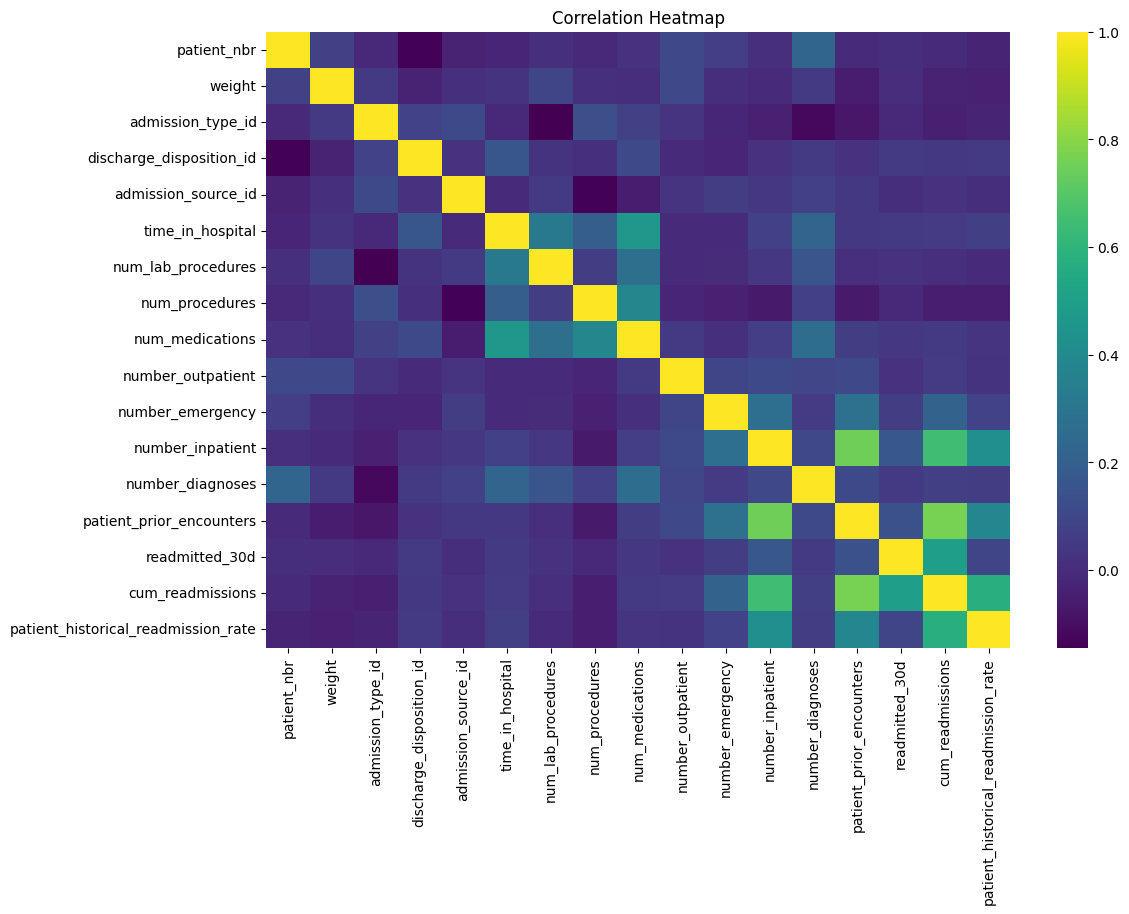

In [90]:
# Create folder if not exists
save_dir = "../Reports/Figures"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12,8))
corr = cleaned_df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Correlation Heatmap")

# SAVE the plot
plt.savefig(os.path.join(save_dir, "correlation_heatmap.png"),
            dpi=300, bbox_inches="tight")

plt.show()


# 7E. Phik Correlation Matrix + Profiling

interval columns not set, guessing: ['patient_nbr', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'patient_prior_encounters', 'readmitted_30d', 'cum_readmissions', 'patient_historical_readmission_rate']


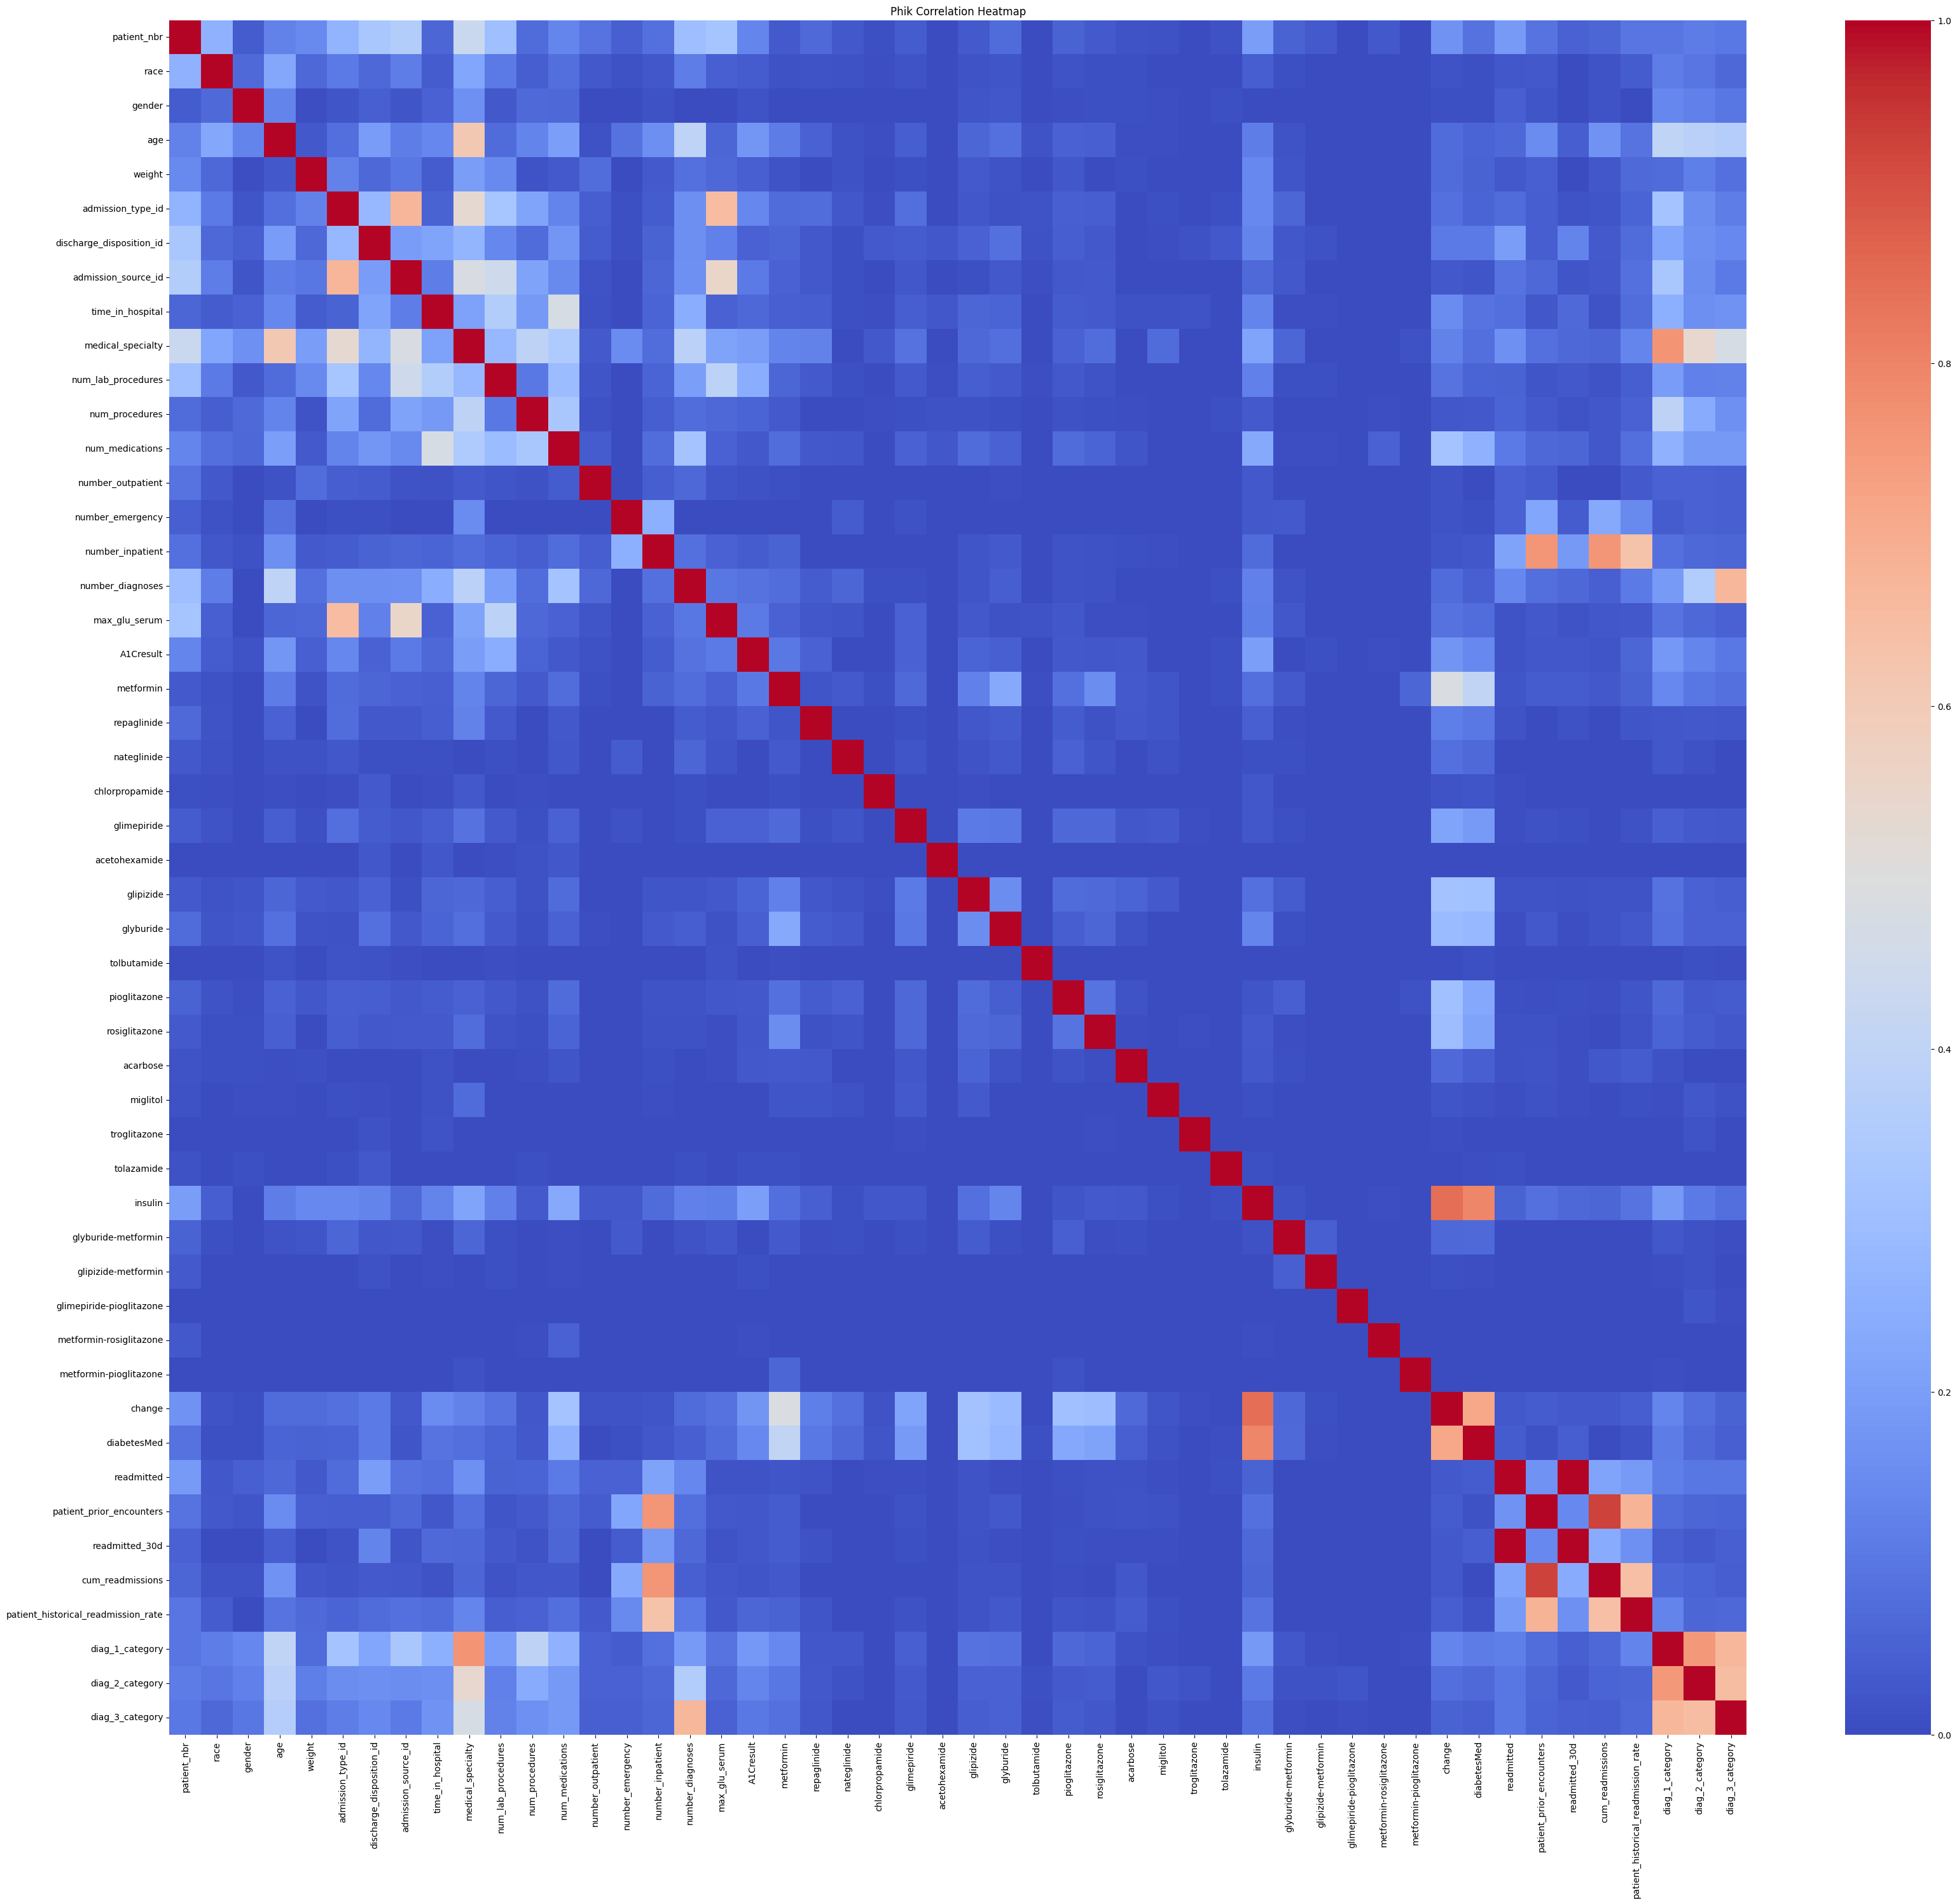

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 17.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [91]:
save_dir = "../Reports/Figures"
os.makedirs(save_dir, exist_ok=True)
phik_corr = cleaned_df.phik_matrix()
plt.figure(figsize=(40,35))
sns.heatmap(phik_corr, cmap='coolwarm')
plt.title("Phik Correlation Heatmap")
# SAVE heatmap
plt.savefig(os.path.join(save_dir, "phik_correlation_heatmap.png"),
            dpi=300, bbox_inches="tight")
plt.show()

# Profiling report
profile = cleaned_df.profile_report(
    title="Phik Report",
    correlations={"phi_k": {"calculate": True}}
)
profile.to_file("../Reports/pydata_profiling/diabetes_report_PhikCorr.html")


# 7F. High Correlation Pair Detection


In [93]:
THRESHOLD = 0.6
phik_abs = phik_corr.abs().copy()
np.fill_diagonal(phik_abs.values, 0)

high_pairs = []
cols = phik_abs.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = phik_abs.iloc[i, j]
        if val >= THRESHOLD:
            high_pairs.append((cols[i], cols[j], val))

high_corr_df = pd.DataFrame(high_pairs, columns=["var1","var2","phik"])
high_corr_df.sort_values("phik", ascending=False)

,var1,var2,phik
11,readmitted,readmitted_30d,1.000000
12,patient_prior_encounters,cum_readmissions,0.929317
8,insulin,change,0.843831
9,insulin,diabetesMed,0.793598
3,medical_specialty,diag_1_category,0.763436
5,number_inpatient,cum_readmissions,0.757904
4,number_inpatient,patient_prior_encounters,0.757887
15,diag_1_category,diag_2_category,0.753078
10,change,diabetesMed,0.714114
13,patient_prior_encounters,patient_historical_readmission_rate,0.682804


# 8. Drop Columns Based on Correlation & Domain Knowledge

In [94]:
# medical_specialty → Dropped because it has many missing/“Unknown” values and
# adds little reliable signal.
# change → Dropped because it is a derived flag and highly redundant with insulin usage.
# diabetesMed → Dropped because it overlaps strongly with insulin and 
# provides no additional information.

#cleaned_df.drop(['medical_specialty','change','diabetesMed'], axis=1, inplace=True)
cleaned_df.shape

(101766, 50)

# 9. Save Cleaned Data

In [95]:
save_path = os.path.join('..', 'Data', 'Processed', 'cleaned_df.pkl')

with open(save_path, 'wb') as f:
    pickle.dump(cleaned_df, f)

print("Saved cleaned_df.pkl →", save_path)

Saved cleaned_df.pkl → ../Data/Processed/cleaned_df.pkl
